In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


In [11]:
def read_text(filename):
    file = open(filename, mode = 'rt', encoding = 'utf-8')
    text = file.read()
    file.close()
    return text

In [17]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [18]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [24]:
deu_eng  = deu_eng[0:50000,:]

In [35]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [38]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [46]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [48]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

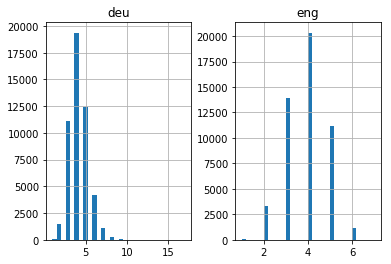

In [50]:
length_df.hist(bins = 30)
plt.show()

In [51]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [58]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6392


In [59]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10760


In [61]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [63]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [67]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [68]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [69]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [71]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [75]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=5, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 1007s 31ms/step - loss: 1.7825 - val_loss: 1.9747

Epoch 00001: val_loss improved from inf to 1.97470, saving model to model.h1.24_jan_19
Epoch 2/5
32000/32000 [==============================] - 999s 31ms/step - loss: 1.6732 - val_loss: 1.9109

Epoch 00002: val_loss improved from 1.97470 to 1.91091, saving model to model.h1.24_jan_19
Epoch 3/5
32000/32000 [==============================] - 1005s 31ms/step - loss: 1.5714 - val_loss: 1.8448

Epoch 00003: val_loss improved from 1.91091 to 1.84476, saving model to model.h1.24_jan_19
Epoch 4/5
32000/32000 [==============================] - 987s 31ms/step - loss: 1.4724 - val_loss: 1.8020

Epoch 00004: val_loss improved from 1.84476 to 1.80203, saving model to model.h1.24_jan_19
Epoch 5/5
32000/32000 [==============================] - 1108s 35ms/step - loss: 1.3837 - val_loss: 1.7348

Epoch 00005: val_loss improved from 1.80203 to 1.7348

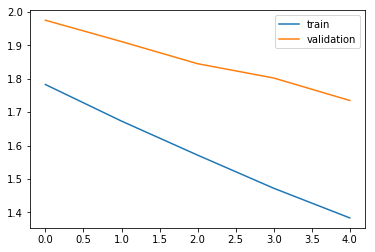

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [77]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [78]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [79]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [80]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [81]:
pd.set_option('display.max_colwidth', 200)

In [82]:
pred_df.head(15)

,actual,predicted
0,i dont care for him,i never to
1,i made tea,i found something
2,no one told me,it might be
3,i saw her swim,i saw to seen
4,tom is in a good mood,tom is a car
5,i guess its not true,i think youre be
6,can you play the piano,can you play the
7,its important to tom,tom is there
8,dont be too sure,arent be sure
9,shes eight years old,shes is
